# 

# GIS (intro)

## What is GIS?

GIS stands for Geographic Information System. It is a system designed to capture, store, manipulate, analyze, manage, and present spatial or geographic data. In other words, GIS is used to create maps and analyze spatial data for a wide range of applications.

In this note, we'll cover some basic GIS concepts and tools that are useful for atmospheric science research.

## What we'll cover
- Define a bounding box of a map, using [geojson.io](http://geojson.io/)
- Download atmospheric data using [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)
- Plot bbox and atmosphere data on a map using [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)
- Repeat above steps, but with time-series data and animations using [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

In [1]:
!uv pip install -r ../requirements.txt

from shapely.geometry import box
import earthkit
import folium
import geopandas as gpd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt


Using Python 3.12.4 environment at: /Users/per.morten.halvorsen@schibsted.com/personal/whale-gis/.venv
Audited 8 packages in 16ms


# Bounding Box

## Polygon

Used https://geojson.io/ to help defined polygon coordinates. 

[Example](https://geojson.io/#new&map=1.78/17.5/-136.2)
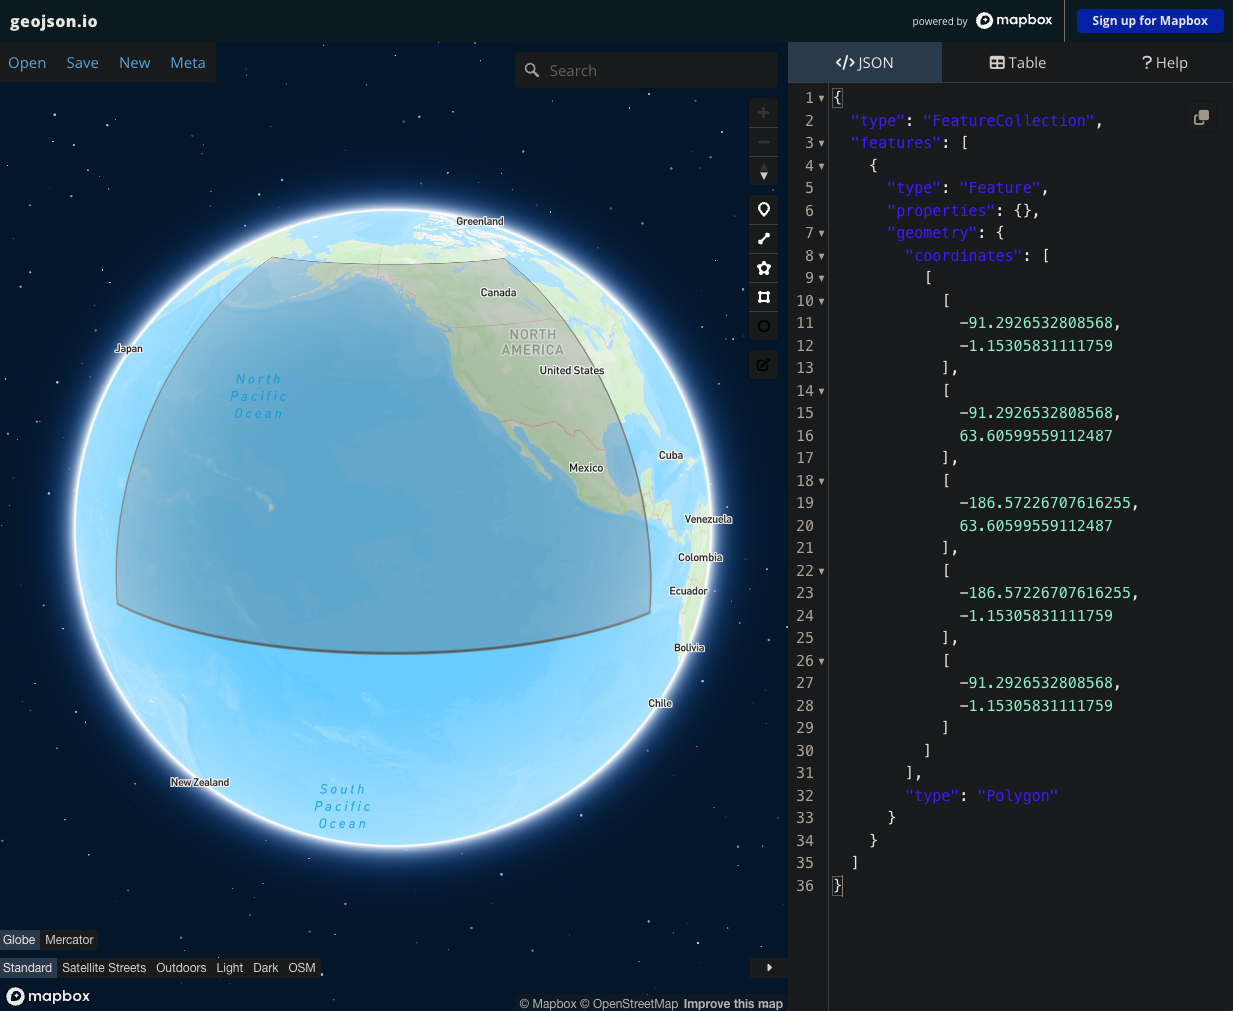

In [2]:
# Use the coordinates of the polygon created as a geometry feature
polygon =   [
  [
    -91.2926532808568,
    -1.15305831111759
  ],
  [
    -91.2926532808568,
    63.60599559112487
  ],
  [
    -186.57226707616255,
    63.60599559112487
  ],
  [
    -186.57226707616255,
    -1.15305831111759
  ],
  [
    -91.2926532808568,
    -1.15305831111759
  ]
]

### wider [polygon](https://geojson.io/#new&map=1.08/4.2/-109.9)

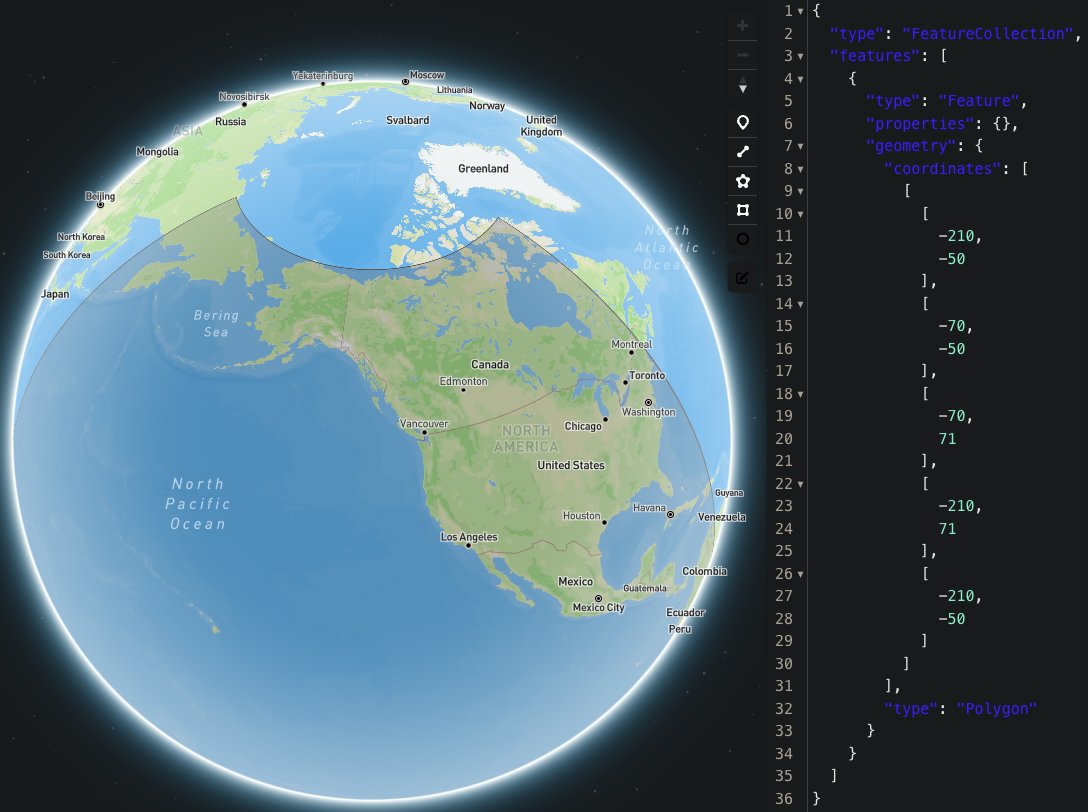
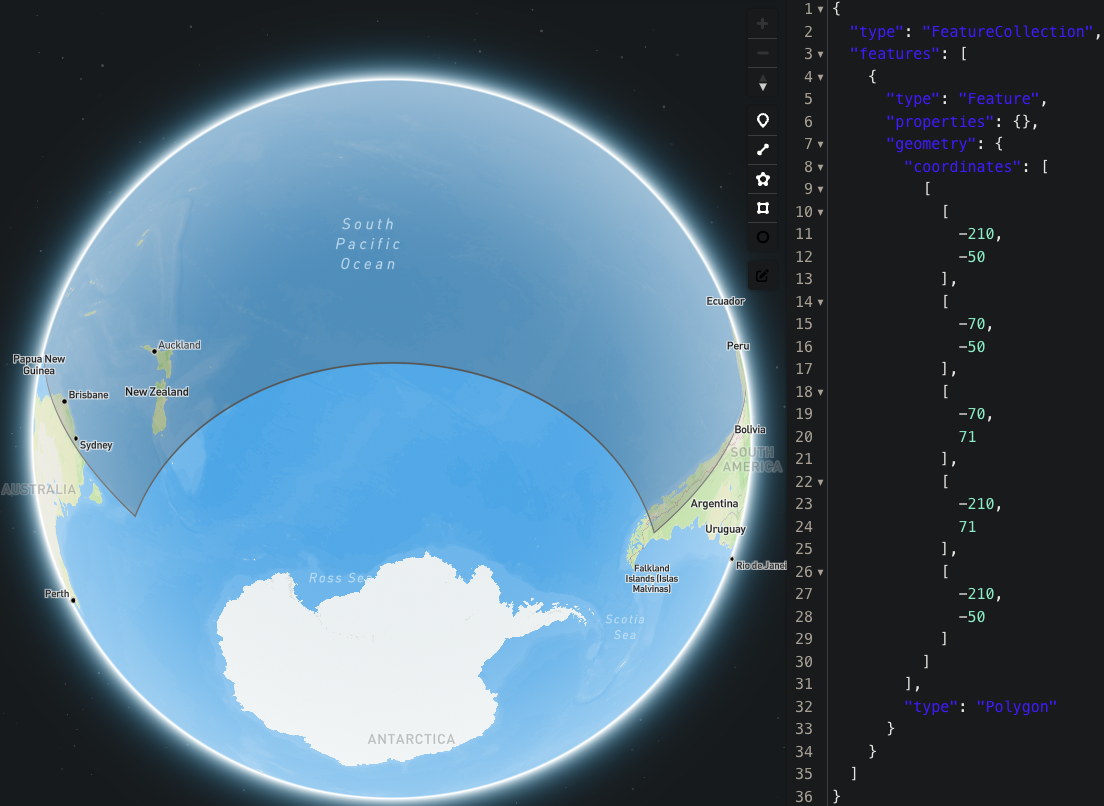
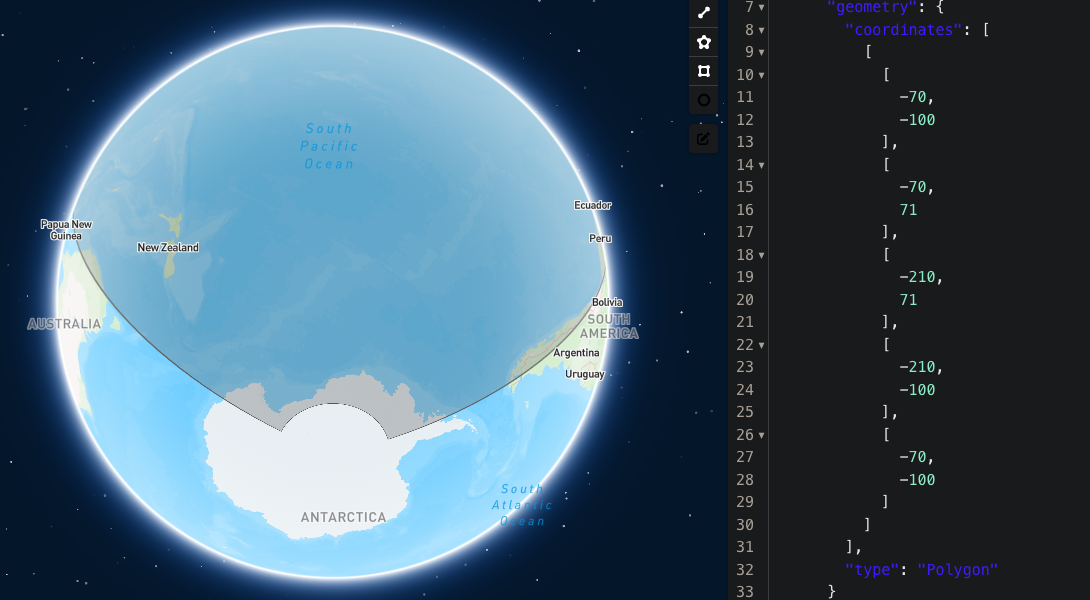
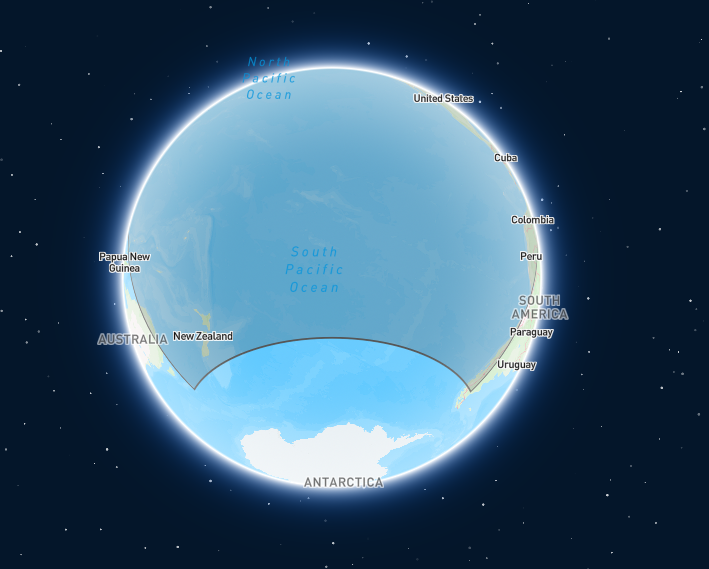
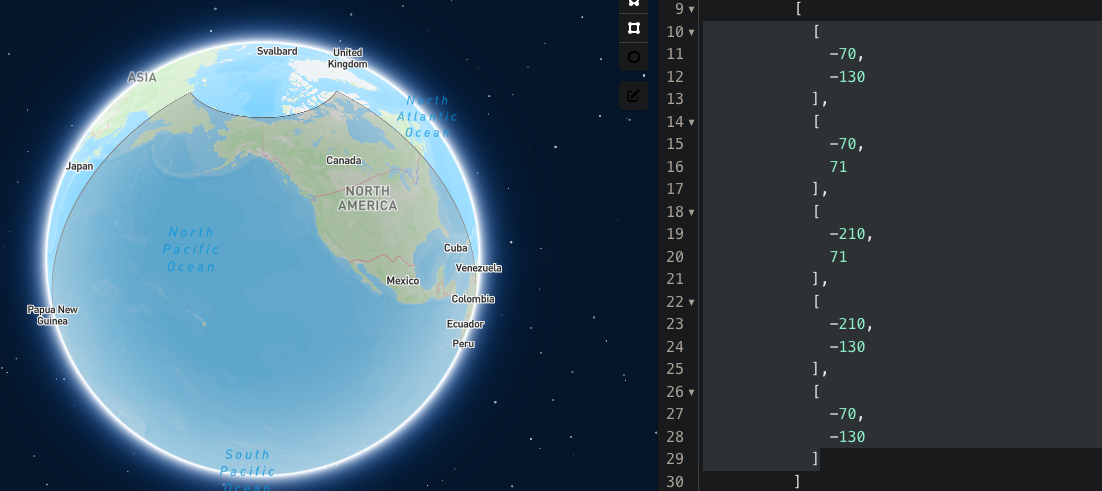
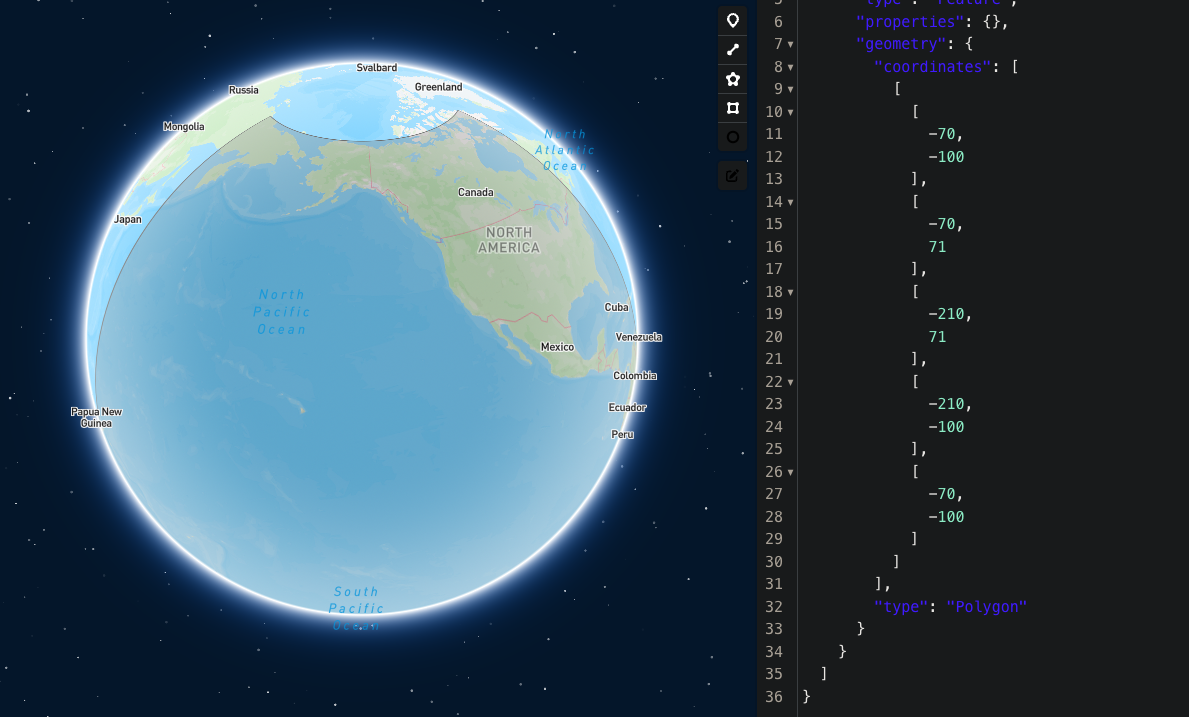

In [3]:
wide_polygon = [
    [
        -210,
        -50
    ],
    [
        -70,
        -50
    ],
    [
        -70,
        71
    ],
    [
        -210,
        71
    ],
    [
        -210,
        -50
    ]
]

## Coordinate utils 

Some helper functions to convert coordinates to bounding box and vice versa.


In [4]:
def nwse_to_midpoint(n, w, s, e):
    """
    Convert north-west-south-east coordinates to latitude-longitude coordinates.
    """
    lat = (n + s) / 2
    lon = (w + e) / 2
    return lat, lon


def nwse_to_radius(n, w, s, e):
    """
    Convert north-west-south-east coordinates to radius.
    """
    lat = (n - s) / 2
    lon = (e - w) / 2
    return lat, lon


def latlon_to_nwse(lat: tuple, lon: tuple):
    """
    Convert latitude-longitude coordinates to north-west-south-east coordinates.

    :params:
        lat: tuple, latitude
        lon: tuple, longitude
    """
    n = lat[0]
    s = lat[1]
    w = lon[0]
    e = lon[1]
    return n, w, s, e


def get_bbox(lat, lon, radius):
    """
    Get bounding box from midpoint latitude, longitude and radius.
    """
    n = lat + radius[0]
    s = lat - radius[0]
    w = lon - radius[1]
    e = lon + radius[1]
    return n, w, s, e


def polygon_to_nwse(poly):
    """
    Get bounding box from polygon.
    """
    lats = [p[1] for p in poly]
    lons = [p[0] for p in poly]
    n = max(lats)
    s = min(lats)
    w = min(lons)
    e = max(lons)
    return n, w, s, e


In [5]:
n,w,s,e = polygon_to_nwse(polygon)

lat, lon = nwse_to_midpoint(n,w,s,e)

print("NWSE:", n,w,s,e)
print("LAT:", lat, "LON:", lon)

NWSE: 63.60599559112487 -186.57226707616255 -1.15305831111759 -91.2926532808568
LAT: 31.226468640003638 LON: -138.93246017850967


In [6]:
n,w,s,e = polygon_to_nwse(wide_polygon)

lat, lon = nwse_to_midpoint(n,w,s,e)

print("NWSE:", n,w,s,e)
print("LAT:", lat, "LON:", lon)

NWSE: 71 -210 -50 -70
LAT: 10.5 LON: -140.0


# Atmospheric data w/ [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)

## API setup

In order to use this package, we needed to create an account to generate an API key, using the following link:
https://cds.climate.copernicus.eu/profile 



You can browse the different datasets available in the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/datasets/), where you'll need to request access to each dataset you'll like to access. In this note, we'll use the [CAMS global reanalysis (EAC4)](https://ads.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download) data.


When running the below code for the first time, you'll likely be asked to provide an API url and key. The key is found in your profile. For the athmosperic data, the endpoint is:
 `https://ads.atmosphere.copernicus.eu/api/`. 

## Download data

In [223]:
# coords = polygon_to_nwse(polygon)
coords = polygon_to_nwse(wide_polygon)


ds = earthkit.data.from_source(
    "ads",
    "cams-global-reanalysis-eac4",
    variable=["particulate_matter_10um", "particulate_matter_1um", "2m_temperature", "mean_sea_level_pressure", "total_column_carbon_monoxide"],
    area=[*coords], # N, W, S, E
    date="2016-12-21",
    time="12:00",
)

ds

2025-01-01 15:44:55,017 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2025-01-01 15:44:55,018 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-01 15:44:55,171 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2025-01-

KeyboardInterrupt: 

### Load GRIB as xarray


In [7]:
ds_path = "/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/tmpjd2n3l9o/ads-retriever-955150200c69f5444550f41bb0638492e02dcf6e5d05a67e3e31f3bdcce35adf.cache"

In [8]:
ds_xr = xr.open_dataset(ds_path, engine='cfgrib')
# ds_xr = ds.to_xarray()
ds_xr

<xarray.Dataset> Size: 807kB
Dimensions:     (latitude: 215, longitude: 187)
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 2kB 70.5 69.75 69.0 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 1kB 150.0 150.8 151.5 ... 288.0 288.8 289.5
    valid_time  datetime64[ns] 8B ...
Data variables:
    pm10        (latitude, longitude) float32 161kB ...
    pm1         (latitude, longitude) float32 161kB ...
    t2m         (latitude, longitude) float32 161kB ...
    msl         (latitude, longitude) float32 161kB ...
    tcco        (latitude, longitude) float32 161kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-01T16:47 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
ds_xr.coords

Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 2kB 70.5 69.75 69.0 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 1kB 150.0 150.8 151.5 ... 288.0 288.8 289.5
    valid_time  datetime64[ns] 8B ...

# Plot geo-data w/ [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)

## Bounding box

Read about WGS84 and EPSG:4326: https://gisgeography.com/wgs84-world-geodetic-system/

In [10]:
coords = polygon_to_nwse(wide_polygon)


def draw_map_bbox(coords):
    n, w, s, e = coords
    lat, lon = nwse_to_midpoint(n, w, s, e)
    # Create a GeoDataFrame with the bounding box (w, s, e, n)
    bbox = gpd.GeoDataFrame({'geometry': [box(w, s, e, n)]})

    # Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    bbox = bbox.set_crs(epsg=4326)

    # Create a folium map centered around the bounding box
    base_map = folium.Map(
        location=[
            lat, 
            lon
        ], 
        zoom_start=2
    )

    # Add the bounding box to the map
    folium.GeoJson(bbox).add_to(base_map)

    # Display the map
    return base_map


base_map = draw_map_bbox(coords)

# Display the map
base_map

## Atmospheric data

In [11]:
def xr_to_nwse(xr):
    """
    Get north-west-south-east coordinates from xarray dataset.
    """
    lats = xr.latitude.values
    lons = xr.longitude.values
    n = float(max(lats))
    s = float(min(lats))
    w = float(min(lons))
    e = float(max(lons))
    return n, w, s, e

xr_to_nwse(ds_xr)

(70.5, 150.0, -90.0, 289.5)

### Particulate matter 10m (pm10)


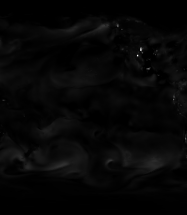

In [12]:
def draw_map_data(xr, variable, opacity=1.0):
    coords = xr_to_nwse(xr)

    map = draw_map_bbox(coords)

    data = xr[variable].values

    # Create a folium raster layer for pm10 data
    folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[
            [coords[2], coords[1]],  # n, w
            [coords[0], coords[3]]   # s, e
        ],
        # colormap=lambda x: (1, 0, 0, x),  # Red colormap
        opacity=opacity
    ).add_to(map)

    return map


draw_map_data(ds_xr, "pm10", 0.7)


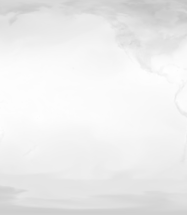

In [13]:

# draw_map_data(ds_xr, "2t", 0.7)
draw_map_data(ds_xr, "t2m", 0.9)


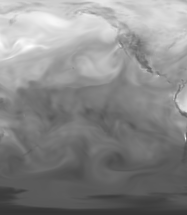

In [14]:
draw_map_data(ds_xr, "tcco", 0.7)

## More plotting 

But with matplotlib

### xaray to matplotlib

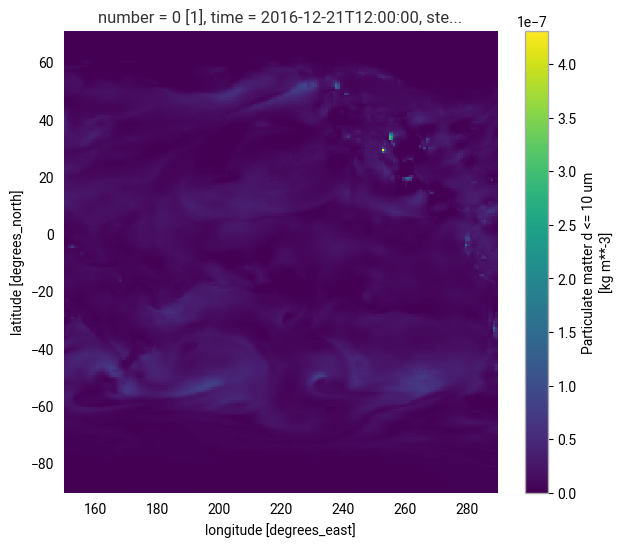

In [15]:
ds_xr["pm10"].plot()

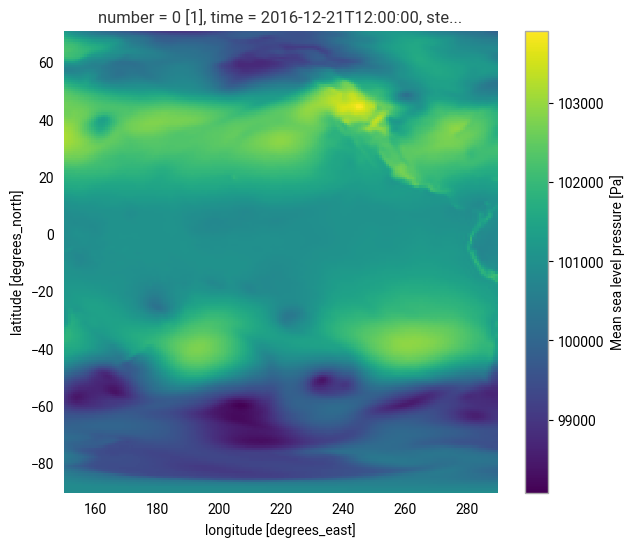

In [16]:
ds_xr["msl"].plot()

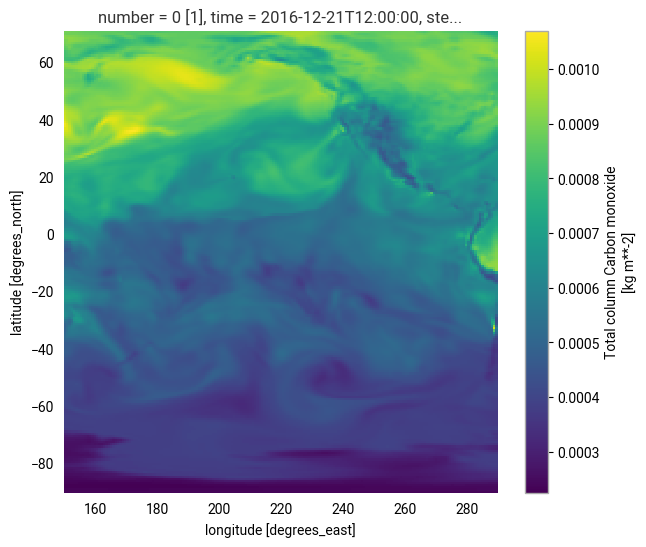

In [17]:
ds_xr["tcco"].plot()

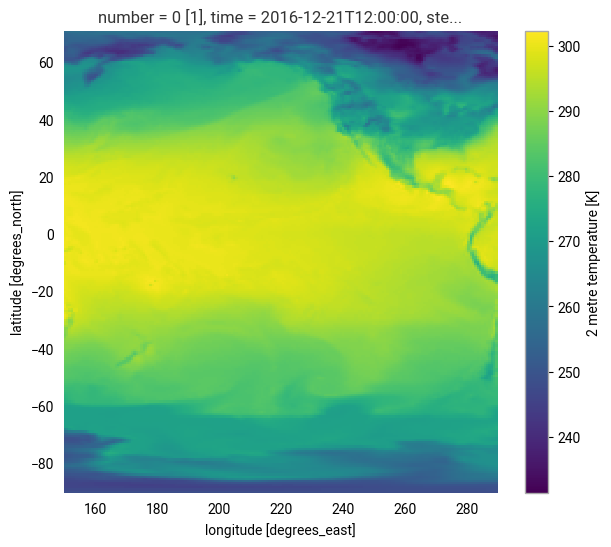

In [18]:
ds_xr["t2m"].plot()

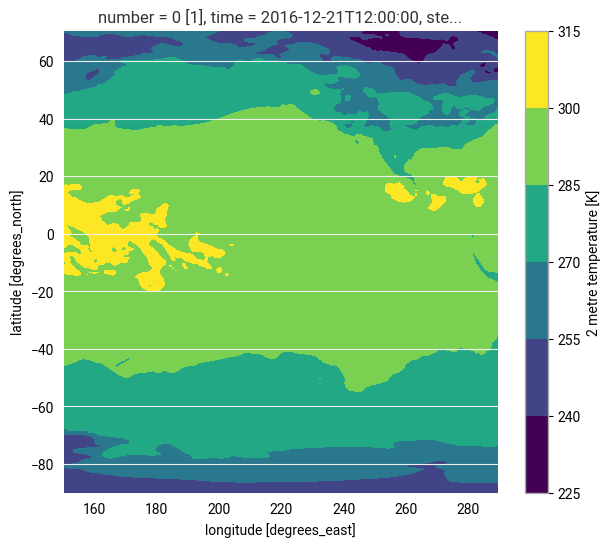

In [19]:
ds_xr["t2m"].plot.contourf()

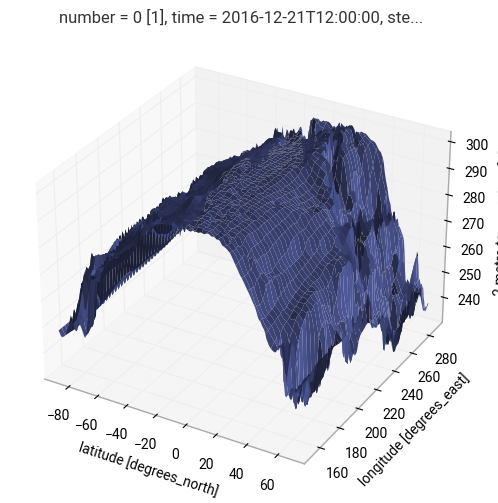

In [20]:
air2d = ds_xr["t2m"]
air2d.T.plot.surface()

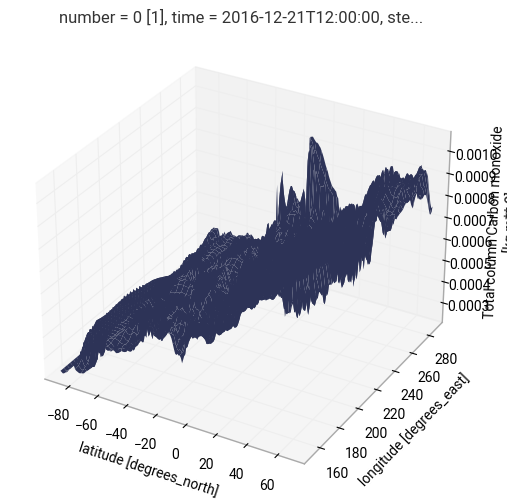

In [21]:
ds_xr["tcco"].T.plot.surface(animated=True)

Plotting in x array 
https://docs.xarray.dev/en/stable/user-guide/plotting.html

In [22]:
lat_idx = 0
lon_idx = 0

lat, lon
ds_xr.isel(latitude=lat_idx, longitude=lon_idx)

<xarray.Dataset> Size: 76B
Dimensions:     ()
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2016-12-21T12:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    latitude    float64 8B 70.5
    longitude   float64 8B 150.0
    valid_time  datetime64[ns] 8B 2016-12-21T12:00:00
Data variables:
    pm10        float32 4B 5.24e-10
    pm1         float32 4B ...
    t2m         float32 4B 256.0
    msl         float32 4B ...
    tcco        float32 4B 0.0008927
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-01T16:47 GRIB to CDM+CF via cfgrib-0.9.1...

### xarray to cartopy



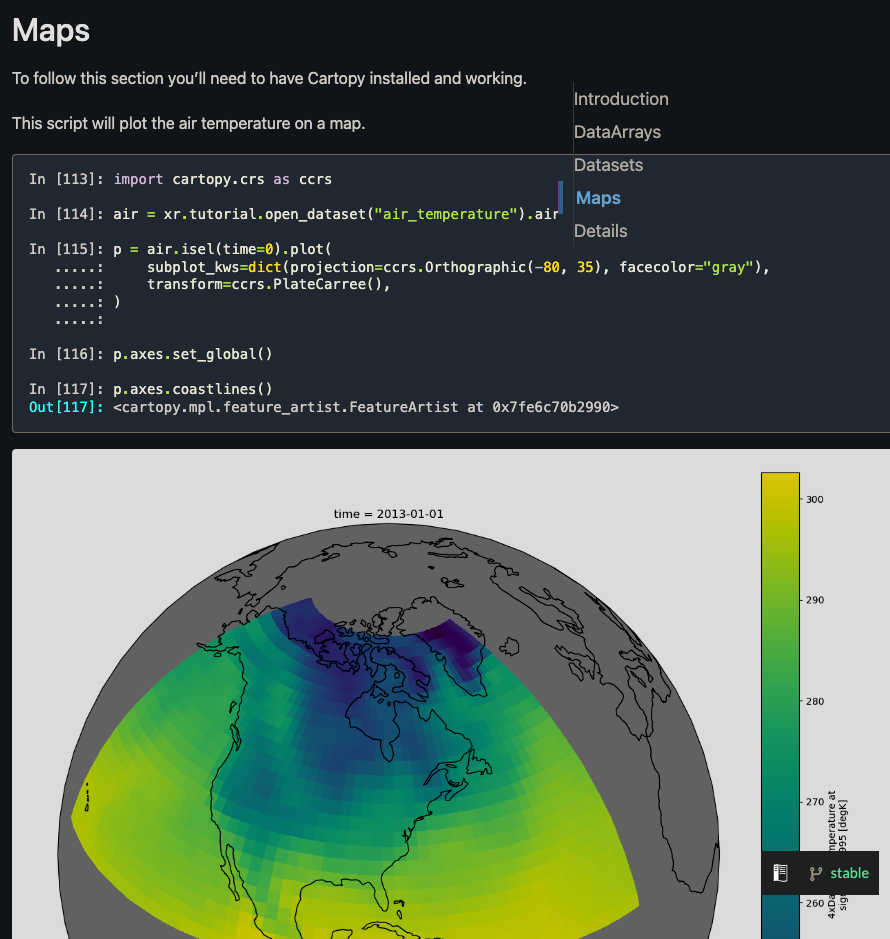

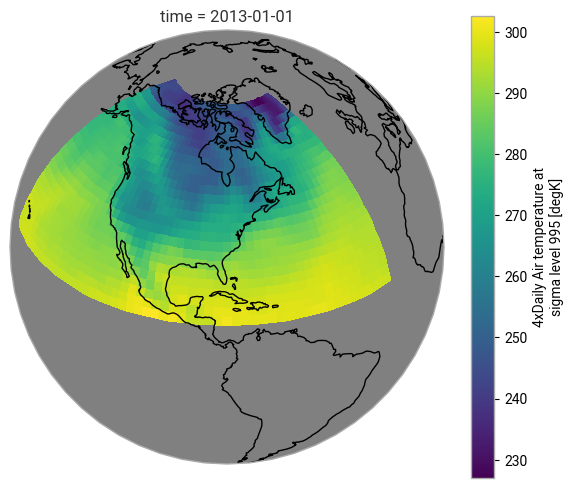

In [23]:
import cartopy.crs as ccrs

air = xr.tutorial.open_dataset("air_temperature").air

p = air.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)


p.axes.set_global()

p.axes.coastlines()

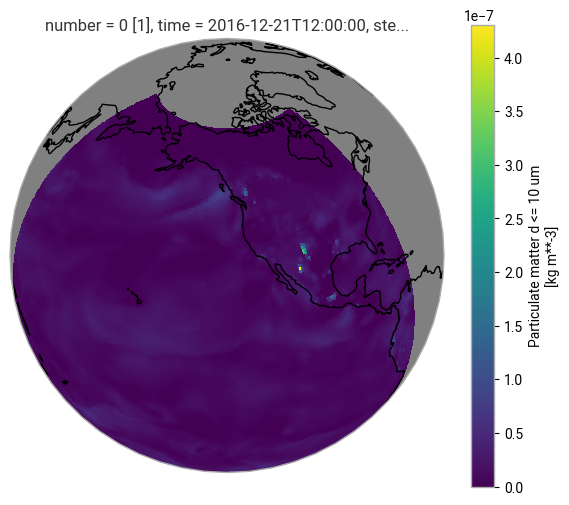

In [24]:
pm10_map = ds_xr["pm10"].plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-130, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

pm10_map.axes.set_global()
pm10_map.axes.coastlines()



# Time-series data and animations

## Data for multiple time steps


In [ ]:
coords = polygon_to_nwse(wide_polygon)

ds_wide_time = earthkit.data.from_source(
    "ads",
    "cams-global-reanalysis-eac4",
    variable=["particulate_matter_10um", "2m_temperature", "mean_sea_level_pressure", "total_column_carbon_monoxide"],
    area=[*coords], # N, W, S, E
    date=["2016-12-21", "2016-12-22"], 
    time=["00:00", "06:00", "12:00", "18:00"],
)

ds_wide_time.path

2024-12-31 14:26:25,165 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-31 14:26:25,166 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-31 14:26:25,385 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-

'/tmp/tmptacb1_eq/ads-retriever-f5c106c0db93736042f233ebbd5bf5ef5119c7a4c943338308f26655ccc3399e.cache'

In [25]:
ds_wide_time_path = '/tmp/tmptacb1_eq/ads-retriever-f5c106c0db93736042f233ebbd5bf5ef5119c7a4c943338308f26655ccc3399e.cache'

In [26]:
ds_wt_xr = xr.open_dataset(ds_wide_time_path, engine='cfgrib')
# ds_wt_xr = ds_wide_time.to_xarray()
ds_wt_xr

<xarray.Dataset> Size: 4MB
Dimensions:     (time: 8, latitude: 162, longitude: 187)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 64B 2016-12-21 ... 2016-12-22T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 70.75 70.0 69.25 ... -48.5 -49.25 -50.0
  * longitude   (longitude) float64 1kB 150.0 150.8 151.5 ... 288.0 288.8 289.5
    valid_time  (time) datetime64[ns] 64B ...
Data variables:
    pm10        (time, latitude, longitude) float32 969kB ...
    t2m         (time, latitude, longitude) float32 969kB ...
    msl         (time, latitude, longitude) float32 969kB ...
    tcco        (time, latitude, longitude) float32 969kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-01T16:48 GRIB to CDM+CF via cfgrib-0.9.1...

## Plotting time-series data

In [27]:
nwse_to_midpoint(*coords)

(10.5, -140.0)

### Static plot

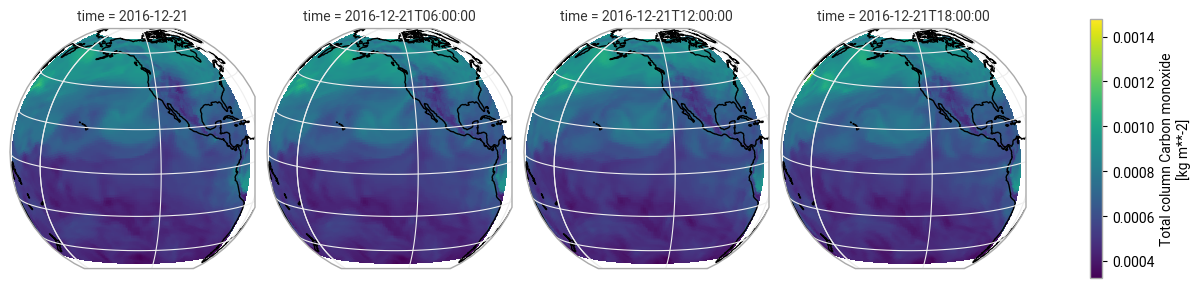

In [28]:
p = ds_wt_xr.isel(time=slice(0,4))["tcco"].plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-130, 10)}, # control the projection
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()

plt.draw()

### Contour animation

We can use the built-in plotting of Xarray with matplotlit's FuncAnimation to animate the data.

Start by selecting a single variable and a slice of time to animate.
We'll also start by plotting the filled contour data, to simplify the animation.

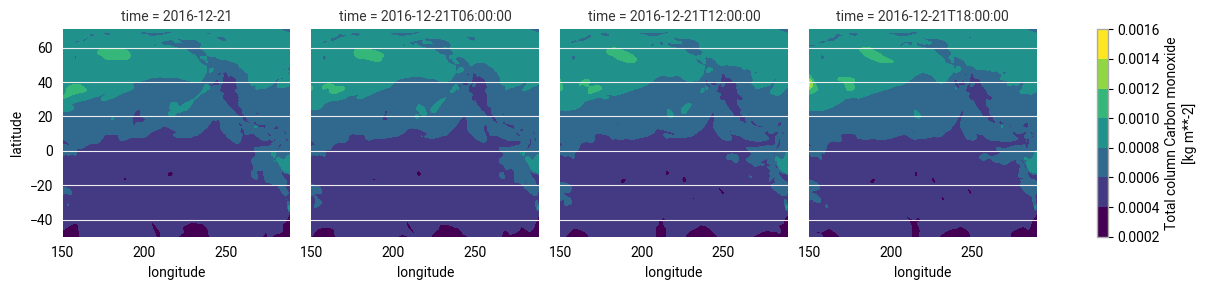

In [31]:
ds_tcco = ds_wt_xr["tcco"].isel(time=slice(0, 4))

ds_tcco.plot.contourf(col="time")

In [32]:
from matplotlib.animation import FuncAnimation
from functools import partial


fig = plt.figure()


def plot_contour(frame, fig, ds, variable):
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-130, 10))

    ds_var = ds[variable]
    # ds_var = ds_tcco
    
    ds_var.isel(time=frame).plot.contourf(
        ax=ax,
        vmin=ds_var.min().item(),
        vmax=ds_var.max().item(),
        transform=ccrs.PlateCarree(),
    )
    
    fig.suptitle(
        f"{variable.upper()}\n\
            Lat: {ds_var.latitude.values.mean().round()} Lon: {ds_var.longitude.values.mean().round()}\n\
            Time: {ds_var.time.values[frame]}"
    )
    ax.set_title("")
    return ax, 


i = 4
animation_function = partial(plot_contour, fig=fig, ds=ds_wt_xr.isel(time=slice(0,i)), variable="tcco")
anim_tcco_contour = FuncAnimation(
    fig = fig,
    func = animation_function,
    frames = i,
    interval = 500,
    blit = False,
)

plt.show()

anim_tcco_contour.save('../data/anim_tcco_contour.gif', writer='pillow')

<Figure size 700x600 with 0 Axes>

![TCCO_Contour_Animation](../data/anim_tcco_contour.gif)

### Surface animations
Let's try building a useful animation of the surface plots. 

#### rotate initial projection

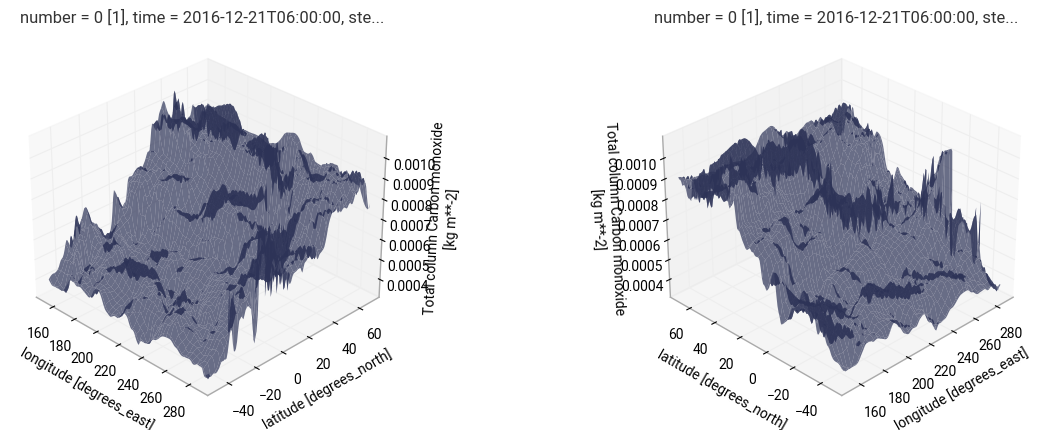

<bound method Figure.figimage of <Figure size 1500x500 with 2 Axes>>

In [33]:
frame = 1

fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})
axs = axs.flatten()

ds_var = ds_wt_xr["tcco"]
    
ds_var.isel(time=frame).plot.surface(
    ax=axs[0],
    alpha=0.7
)
    
ds_var.isel(time=frame).plot.surface(
    ax=axs[1],
    alpha=0.7
)

# rotate
axs[0].view_init(azim=-45, elev=30)
axs[1].view_init(azim=-135, elev=30)

plt.show()

fig.figimage

#### basemap w/ coastlines

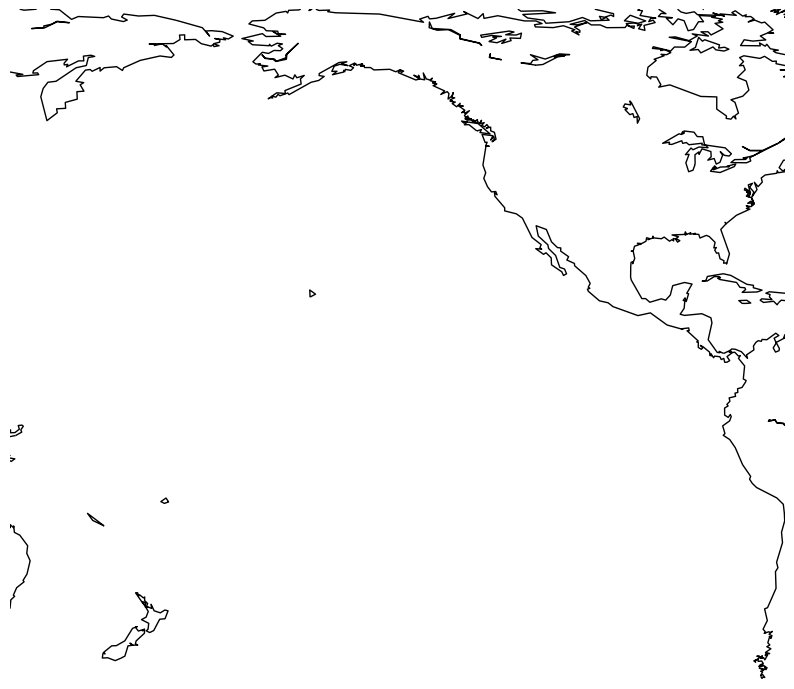

In [41]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(
    llcrnrlon=ds_var.longitude.values.min().round(),
    llcrnrlat=ds_var.latitude.values.min().round(),
    urcrnrlon=ds_var.longitude.values.max().round(),
    urcrnrlat=ds_var.latitude.values.max().round(),
)

m.drawcoastlines()

plt.show()

#### basemap in 3d projection

/tmp/ipykernel_51868/3386625230.py:30: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for zlev, collection in zip(cs.levels, cs.collections):


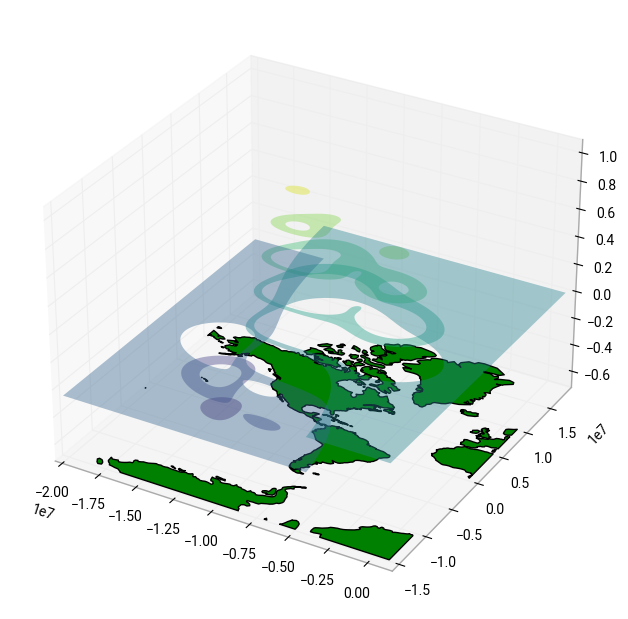

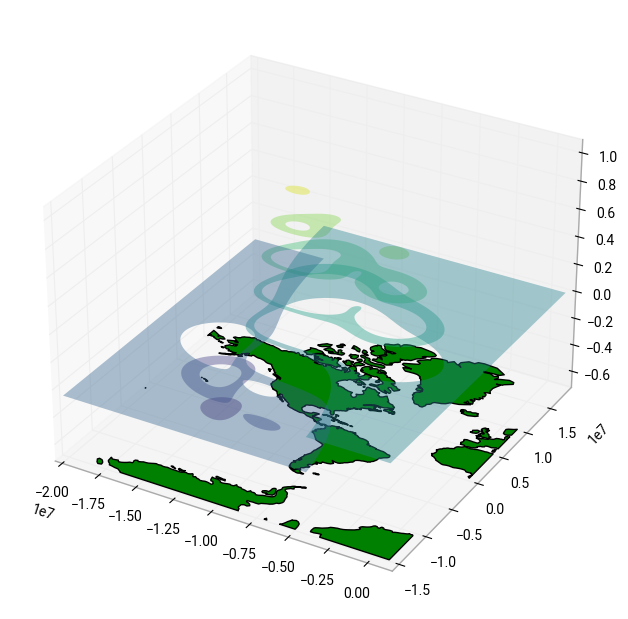

In [51]:
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.patch import geos_to_path

import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PolyCollection
import numpy as np


def f(x,y):
    x, y = np.meshgrid(x, y)
    return (1 - x / 2 + x**5 + y**3 + x*y**2) * np.exp(-x**2 -y**2)

nx, ny = 256, 512
X = np.linspace(-180, 10, nx)
Y = np.linspace(-90, 90, ny)
Z = f(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))


fig = plt.figure()
ax3d = fig.add_axes([0, 0, 1, 1], projection='3d')

# Make an axes that we can use for mapping the data in 2d.
proj_ax = plt.figure().add_axes([0, 0, 1, 1], projection=ccrs.Mercator())
cs = proj_ax.contourf(X, Y, Z, transform=ccrs.PlateCarree(), alpha=0.4)


for zlev, collection in zip(cs.levels, cs.collections):
    paths = collection.get_paths()
    # Figure out the matplotlib transform to take us from the X, Y coordinates
    # to the projection coordinates.
    trans_to_proj = collection.get_transform() - proj_ax.transData

    paths = [trans_to_proj.transform_path(path) for path in paths]
    verts3d = [np.concatenate([path.vertices,
                               np.tile(zlev, [path.vertices.shape[0], 1])],
                              axis=1)
               for path in paths]
    codes = [path.codes for path in paths]
    pc = Poly3DCollection([])
    pc.set_verts_and_codes(verts3d, codes)

    # Copy all of the parameters from the contour (like colors) manually.
    # Ideally we would use update_from, but that also copies things like
    # the transform, and messes up the 3d plot.
    pc.set_facecolor(collection.get_facecolor())
    pc.set_edgecolor(collection.get_edgecolor())
    pc.set_alpha(collection.get_alpha())

    ax3d.add_collection3d(pc)

proj_ax.autoscale_view()

ax3d.set_xlim(*proj_ax.get_xlim())
ax3d.set_ylim(*proj_ax.get_ylim())
ax3d.set_zlim(Z.min(), Z.max())


# Now add coastlines.
concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = proj_ax.projection

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

# Use the convenience (private) method to get the extent as a shapely geometry.
boundary = proj_ax._get_extent_geom()

# Transform the geometries from PlateCarree into the desired projection.
geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]
# Clip the geometries based on the extent of the map (because mpl3d can't do it for us)
geoms = [boundary.intersection(geom) for geom in geoms]

# Convert the geometries to paths so we can use them in matplotlib.
paths = concat(geos_to_path(geom) for geom in geoms)
polys = concat(path.to_polygons() for path in paths)
lc = PolyCollection(polys, edgecolor='black',
                    facecolor='green', closed=True)
ax3d.add_collection3d(lc, zs=ax3d.get_zlim()[0])

plt.close(proj_ax.figure)
plt.show() 

fig

In [ ]:
def plot_surface(frame, fig, ds, variable):
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-130, 10))

    ds_var = ds[variable]
    # ds_var = ds_tcco
    
    ds_var.isel(time=frame).plot.contourf(
        ax=ax,
        vmin=ds_var.min().item(),
        vmax=ds_var.max().item(),
        transform=ccrs.PlateCarree(),
    )
    
    fig.suptitle(
        f"{variable.upper()}\n\
            Lat: {ds_var.latitude.values.mean().round()} Lon: {ds_var.longitude.values.mean().round()}\n\
            Time: {ds_var.time.values[frame]}"
    )
    ax.set_title("")
    return ax, 
